References:
otoro's [post](http://blog.otoro.net/2015/12/12/handwriting-generation-demo-in-tensorflow/)

## Model Definition

Implementation summary
- Two layer GRU + linear. The linear layer maps GRU outputs from [-1,1] to [-inf, inf]
- use logsumexp( ) for numerical stability with close to zero values
- 2D Gaussian sampling impleneted with Gibb's sampling
- Default dropout rate = 0.2, rnn_size = 256, number of Gaussian used = 20.
- No peephole connections.

### Intuition

*In human language*: Each line of writing consists of strokes. Each stroke consists of points. We are going to predict random handwritings on the point level. Namely, given a current point, predict the next point position.

*In modeling language*: Use a Gaussian mixture model(GMM) to predict the distribution of points. GMM hyper-parameters are predicited by a neural network, based on the previous point and a hidden state. This design is similar to Character-level RNN, in which we replace each point with a character and replace GMM with multinomial logistic regression.

### Input layer
Each stroke consists of a series of connected points (x,y), but $\Delta_x ,\Delta_y$ are used as inputs instead. The end of stroke (eos) signal is also included in the input. When eos equals one, the pen is lifted, and a continuous stroke is finished. As a result, the input layer dimension is [sequence_size, batch_size, 3].

### Output layer
The output layer contains hyper-parameters for a Gaussian mixture model and a Bernoulli distribution. 

- The Gaussian mixture model is used to predict the next $\Delta_x ,\Delta_y$ segament based on the current value. $\Pi_i$'s are weights assigned to each Gaussian.

$pdf(\Delta_x ,\Delta_y) = \sum_{i=1}^{20}{\Pi_i \cdot N(\mu, \Sigma})$

- The Bernoulli mixture model is used to predict the next eos signal with a binary logistic regression model.

$pmf(eos) = sigmoid(logit)$

### Loss function

The intuition is to maximize likelihoods/probability of observing training data, so the loss fuciton is naturally the negative sum of Gaussian and Berboulli. 
- Quite commonly, we maximize their logarithm values instead. 
- Gaussian loss is in fact much larger than Bernoulli loss, but there is no need to worry one would overshadow the other. Because backpropagation follows symbolic graph, gradients are automatically sapareted for the two loss functions.

#### Some handy equations
> **Bivariate Gaussian Distribution** from [wolfram](http://mathworld.wolfram.com/BivariateNormalDistribution.html).
![](http://mathworld.wolfram.com/images/equations/BivariateNormalDistribution/NumberedEquation1.gif)
where
![](http://mathworld.wolfram.com/images/equations/BivariateNormalDistribution/NumberedEquation2.gif)


> **Bernoulli distribution** from [wiki](https://en.wikipedia.org/wiki/Bernoulli_distribution)
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/db3fd41462403c968c851f840407813d1f801fb8)


> **Equations for Gibbs sampling** from [here](http://www.maths.qmul.ac.uk/~ig/MTH5118/Notes11-09.pdf).

>marginal $ pdf_y = \frac{1}{\sqrt{2\pi}\sigma_2} \exp{(- \frac{(y-\mu_2)^2}{2\sigma_2^2})}$

> conditional $ pdf_{x|y} = \frac{1}{\sqrt{2\pi (1-\rho^2)}\sigma_1} \exp{(- \frac{(x-a(y))^2}{2\sigma_1^2 (1-\rho^2)})}$

> where

> $ a(y) = \mu_1 + \rho \frac{\sigma_1}{\sigma_2} (y-\mu_2) $

In [10]:
import random
import math
import torch
from torch import nn, optim
from torch.autograd import Variable

def logsumexp(x):
    x_max, _ = x.max(dim=1,keepdim=True)
    x_max_expand = x_max.expand(x.size())
    res =  x_max + torch.log((x-x_max_expand).exp().sum(dim=1, keepdim=True))
    return res

class GaussianHandWriting(nn.Module):
    def __init__(self, n_gaussian=20,dropout=0,rnn_size=256):
        super(GaussianHandWriting, self).__init__()
        self.n_gaussian = n_gaussian
        self.rnn_size=rnn_size
        self.n_output = 1 + n_gaussian*6
        self.rnn = nn.GRU(3,self.rnn_size,2,dropout=dropout)
        self.linear = nn.Linear(self.rnn_size,self.n_output)
    def forward(self, input, hidden=None):
        output, hidden = self.rnn(input,hidden)
        output = output.view(-1,self.rnn_size)
        output = self.linear(output)
        mu1, mu2, log_sigma1, log_sigma2, rho, pi_logits, z0_logits = \
        output.split(self.n_gaussian,dim=1)
        rho = nn.functional.tanh(rho)
        return mu1, mu2, log_sigma1, log_sigma2, rho, pi_logits, z0_logits, hidden
    def calculate_loss(self, x, xNext, hidden=None):
        batch_size = x.size(1)
        mu1, mu2, log_sigma1, log_sigma2, rho, pi_logits, z0_logits, hidden = self.forward(x, hidden)
        xNext = xNext.view(-1,3)
        x1, x2, x_eos = xNext.split(1,dim=1)
        loss1 = - self.logP_gaussian(x1, x2, mu1, mu2, log_sigma1, log_sigma2, rho, pi_logits)
        loss2 = nn.functional.binary_cross_entropy_with_logits(z0_logits,x_eos,size_average=False)
        loss = (loss1 + loss2)/batch_size # average over mini-batch
        return loss, hidden
    def logP_gaussian(self,x1, x2, mu1, mu2, log_sigma1, log_sigma2, rho, pi_logits):
        x1, x2 = x1.repeat(1,self.n_gaussian), x2.repeat(1,self.n_gaussian)
        sigma1, sigma2 = log_sigma1.exp(), log_sigma2.exp()
        log_pi = nn.functional.log_softmax(pi_logits)
        z_tmp1, z_tmp2 = (x1-mu1)/sigma1, (x2-mu2)/sigma2
        z = z_tmp1**2 + z_tmp2**2 - 2*rho*z_tmp1*z_tmp2
        # part one
        log_gaussian = - math.log(math.pi*2)-log_sigma1 - log_sigma2 - 0.5*(1-rho**2).log()
        # part two
        log_gaussian += - z/2/(1-rho**2)
        # part three
        log_gaussian = logsumexp(log_gaussian + log_pi)
        return log_gaussian.sum()
    def draw_one_sample(self, mu1, mu2, log_sigma1, log_sigma2, rho, pi_logits, z0_logits):
        # draw Gaussian mixture
        pi = nn.functional.softmax(pi_logits)
        idx, = random.choices(range(self.n_gaussian), weights = pi.data.tolist()[0])
        sigma1, sigma2 = log_sigma1.exp(), log_sigma2.exp()
        x1 = torch.normal(mu1[:,idx],sigma1[:,idx]) # size = 1,
        mu2 = mu2+rho*(log_sigma2-log_sigma1).exp()*(x1-mu1)
        sigma2 = (1-rho**2)**0.5 * sigma2
        x2 = torch.normal(mu2[:,idx], sigma2[:,idx])$\Delta
        p_bernoulli = nn.functional.sigmoid(z0_logits)
        eos = torch.bernoulli(p_bernoulli)
        return torch.cat([x1,x2,eos]).view(1,1,3)
    def generate(self, x0, hidden=None, n=100):
        res = []
        sample = x0
        for i in range(n):
            mu1, mu2, log_sigma1, log_sigma2, rho, pi_logits, z0_logits, hidden = \
            self.forward(sample, hidden)
            sample = self.draw_one_sample(mu1, mu2, log_sigma1, log_sigma2, rho, pi_logits, z0_logits)
            res.append(sample.data.tolist()[0][0])
        return res

#For Test
#
# x = Variable(torch.rand(5,10,3))
# net = GaussianHandWriting(n_gaussian=10,dropout=0.2)
# net(x)
# net.calculate_loss(x[:-1],x[1:])
# net.generate((Variable(torch.ones(1,1,3))))

## Utility functions to process IAM On-line handwriting database (XML)

IAM database is available from [here](http://www.fki.inf.unibe.ch/databases/iam-on-line-handwriting-database). Registration is needed for a free download. This part is boring. Samples aare shown in the figure below. Each stroke is colored differently.

- Use beautifulsoup to parse XML files.
- extract_points( ) function reads one XML file, and extract raw coordinates (x,y).
- sample_xml( ) function utilizes the above funtion, samples random XML files and calculates ($\Delta_x,\Delta_y$). Values are clipped between -500 and 500. The *factor* is used to scaled downward the coordinates.
- plot_points( ) helps to visulize handwriting data.
- batch_generator( ) provides unlimited batch data for the training later.

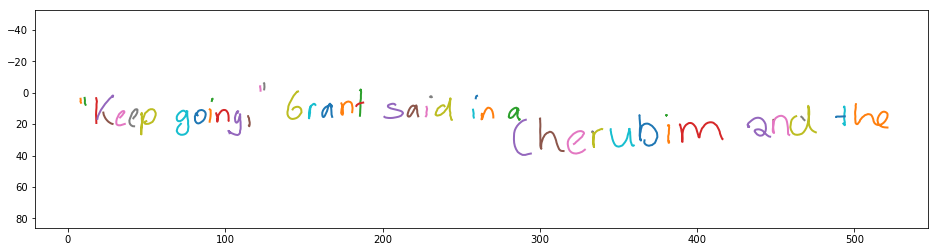

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup as Soup
import numpy as np
import glob

def extract_points(filename):
    with open(filename,'r') as f:
        soup = Soup(f.read(),'lxml')
    pts = [ [float(pt['x']), float(pt['y'])] for pt in soup.find_all('point')]
    pen_lifts = []
    for stroke in soup.find_all('stroke'):
        pen_lifts += [0]*(len(stroke.find_all('point'))-1) +[1]
    return pts, pen_lifts

path = '/Users/winter/Downloads/lineStrokes/**/*.xml'
all_files = list(glob.iglob(path,recursive=True))

def sample_xml(batch_size=1, factor=20):
    pts = []
    pen_lifts = []
    for filename in np.random.choice(all_files,batch_size,replace=False):
        _pts, _pen_lifts = extract_points(filename)
        _pts, _pen_lifts = np.array(_pts), np.array(_pen_lifts)
        _pts, _pen_lifts = _pts - np.roll(_pts,1,axis=0), _pen_lifts
        _pts[0][0] = 100
        _pts[0][1] = 0
        _pen_lifts[0] = 1
        _pts = np.minimum(np.maximum(_pts,-500),500)/factor
        pts += _pts.tolist()
        pen_lifts += _pen_lifts.tolist()
    res = [v1+[v2,] for v1,v2 in zip(pts,pen_lifts)]
    return res

def plot_points(data):
    plt.figure(figsize=[16,4])
    plt.gca().invert_yaxis()
    plt.axis('equal')
    pts = np.array(data).cumsum(axis=0)
    data[-1][-1] = 1
    idx = [i for i, v in enumerate(data) if data[i][-1]==1]
    start = 0
    for end in idx:
        tmp = pts[start:end+1]
        plt.plot(tmp[:,0], tmp[:,1], linewidth=2)
        start = end+1
        
def batch_generator(seq_size=300, batch_size=50):
    cache = []
    data_size = seq_size*batch_size
    while True:
        if len(cache)<data_size:
            cache += sample_xml(1000)
        else:
            x = torch.Tensor(cache[:data_size])\
                     .view(batch_size,seq_size,3)\
                     .transpose(0,1)\
                     .contiguous()
            cache = cache[data_size:]
            yield Variable(x)
            
data = sample_xml(2)
plot_points(data)

## Training

The whole training process is unsupervised. Following regularizations are used.
- Adam Optimizer
- Gradient clipping
- Dropout rate = 0.2

Make sure to detach hidden states ater gradiens updates. Otherwise, hidden states are still connected to previous graphs. 

If you look at the calculate_loss function defined in the model class, the loss is divided only by batch_size. If the loss is divided by *sequence_size*, it is equivalent to reduce learning rate to *1/sequence_size*.

epoch 0, loss 1720.8404541015625


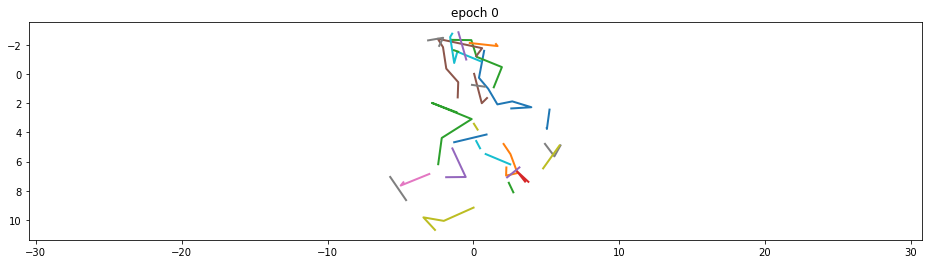

epoch 10, loss 715.0220947265625
epoch 20, loss 371.820068359375
epoch 30, loss 321.6590576171875
epoch 40, loss 243.1714630126953
epoch 50, loss 196.3934783935547
epoch 60, loss 130.6112060546875
epoch 70, loss 170.08526611328125
epoch 80, loss 170.83233642578125
epoch 90, loss 177.57835388183594
epoch 100, loss 109.2279281616211


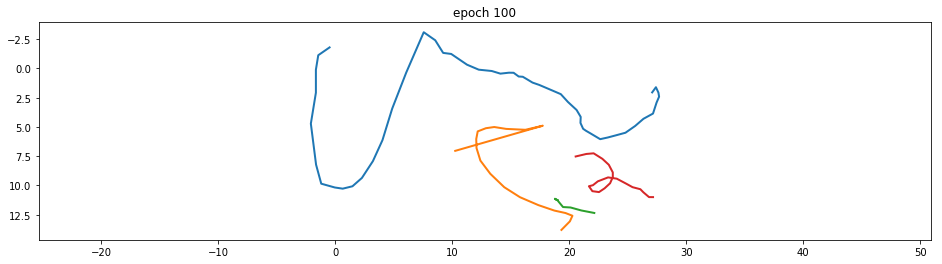

epoch 110, loss 134.0895538330078
epoch 120, loss 141.91783142089844
epoch 130, loss 110.62458801269531
epoch 140, loss 149.23162841796875
epoch 150, loss 89.91399383544922
epoch 160, loss 91.32146453857422
epoch 170, loss 104.75334167480469
epoch 180, loss 100.30490112304688
epoch 190, loss 49.739410400390625
epoch 200, loss 134.3074493408203


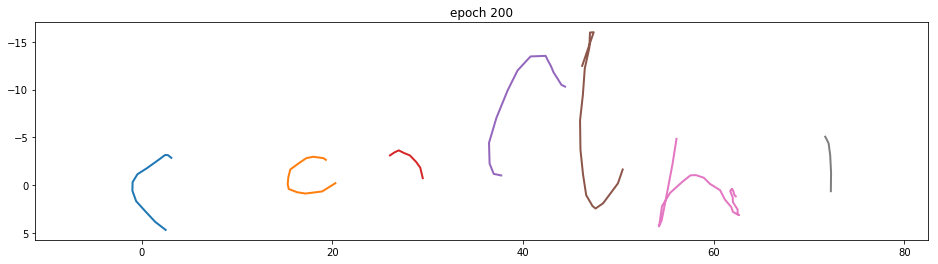

epoch 210, loss 85.12063598632812
epoch 220, loss 86.92639923095703
epoch 230, loss 89.70089721679688
epoch 240, loss 45.846553802490234
epoch 250, loss 37.76823425292969
epoch 260, loss 31.961181640625
epoch 270, loss 87.22055053710938
epoch 280, loss 88.57913208007812
epoch 290, loss 64.62517547607422
epoch 300, loss 78.60204315185547


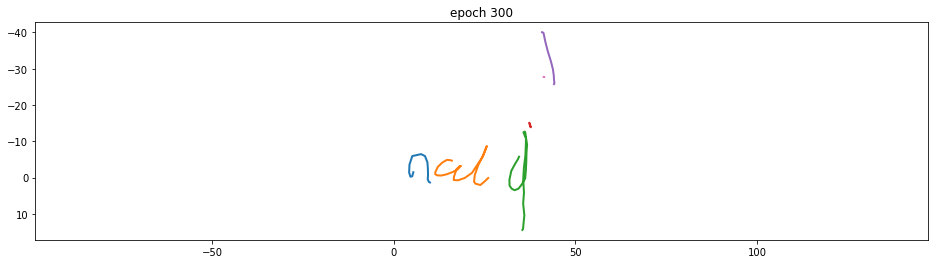

epoch 310, loss 60.83543395996094
epoch 320, loss 60.822086334228516
epoch 330, loss 36.7750244140625
epoch 340, loss 0.8988623023033142
epoch 350, loss 65.21821594238281
epoch 360, loss 49.64619064331055
epoch 370, loss 27.786357879638672
epoch 380, loss 46.25798034667969
epoch 390, loss 7.223459243774414
epoch 400, loss 25.316965103149414


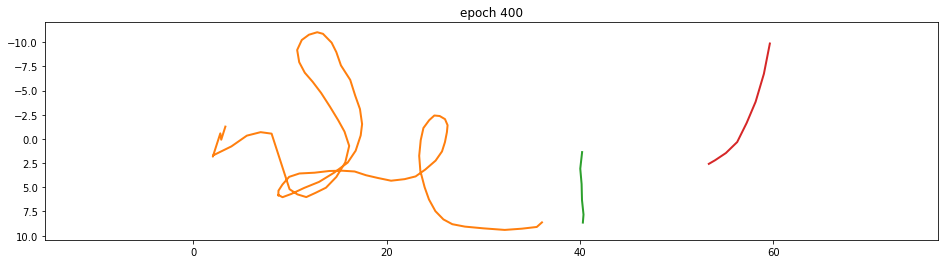

epoch 410, loss 23.3996524810791
epoch 420, loss 88.06482696533203
epoch 430, loss 33.20637893676758
epoch 440, loss 95.45243835449219
epoch 450, loss 24.35494613647461
epoch 460, loss 48.131099700927734
epoch 470, loss 52.2957878112793
epoch 480, loss 41.05231475830078
epoch 490, loss 30.5067195892334
epoch 500, loss 43.30693435668945


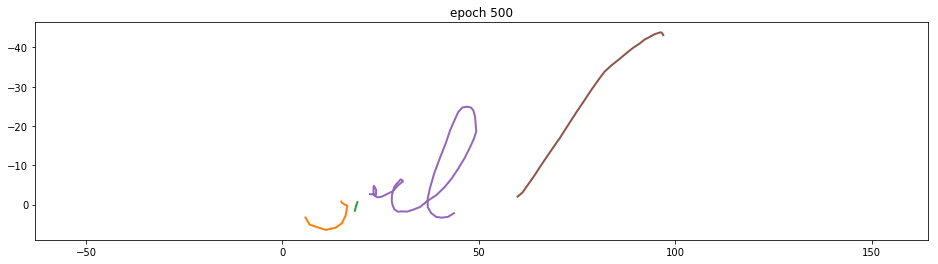

epoch 510, loss 43.51206970214844
epoch 520, loss 8.11175537109375
epoch 530, loss 53.10029220581055
epoch 540, loss 73.51412963867188
epoch 550, loss 17.060758590698242
epoch 560, loss 22.948965072631836
epoch 570, loss 8.364343643188477
epoch 580, loss -14.724706649780273
epoch 590, loss 66.61451721191406
epoch 600, loss 21.261550903320312


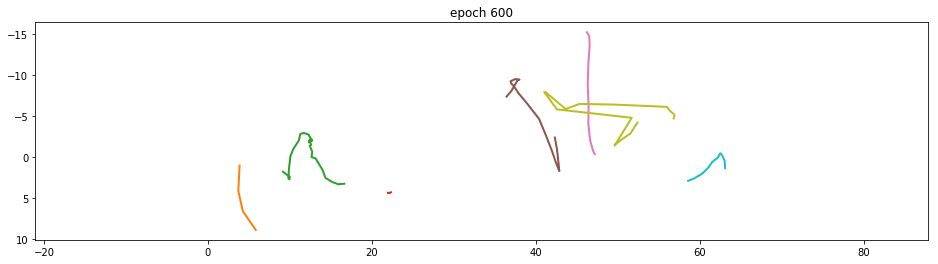

epoch 610, loss 18.68976593017578
epoch 620, loss 61.84482955932617
epoch 630, loss 78.4582748413086
epoch 640, loss -4.728317737579346
epoch 650, loss 51.91793441772461
epoch 660, loss 9.831689834594727
epoch 670, loss 25.269643783569336
epoch 680, loss 14.83563232421875
epoch 690, loss 33.029441833496094
epoch 700, loss 58.76475143432617


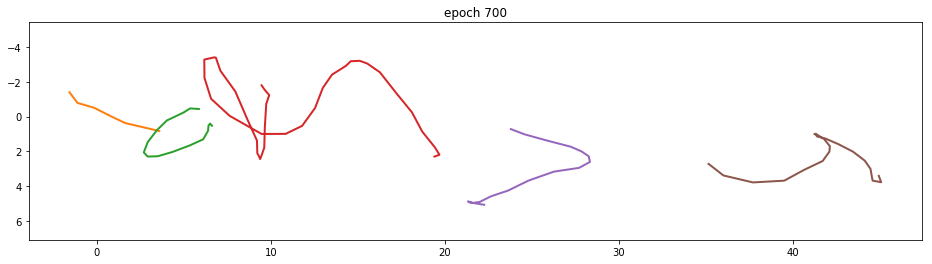

epoch 710, loss 23.46332550048828
epoch 720, loss 39.209293365478516
epoch 730, loss 31.223508834838867
epoch 740, loss -28.098041534423828
epoch 750, loss 5.37753438949585
epoch 760, loss 62.04689407348633
epoch 770, loss -12.322173118591309
epoch 780, loss -8.3683443069458
epoch 790, loss -4.332798004150391
epoch 800, loss 5.874143123626709


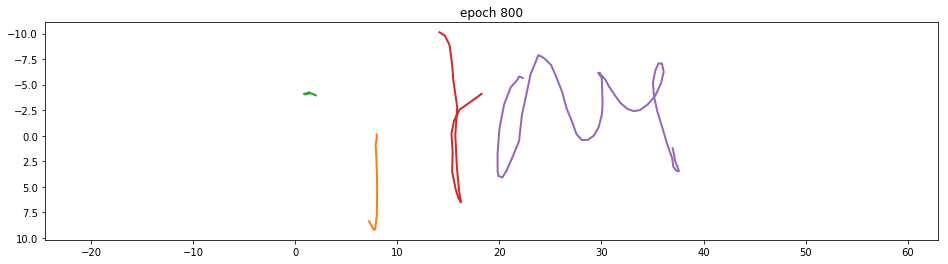

epoch 810, loss -31.123218536376953
epoch 820, loss 15.085456848144531
epoch 830, loss 8.7203369140625
epoch 840, loss 15.115251541137695
epoch 850, loss -11.162578582763672
epoch 860, loss -11.611525535583496
epoch 870, loss 55.634376525878906
epoch 880, loss 43.247989654541016
epoch 890, loss -0.6787646412849426
epoch 900, loss 23.080198287963867


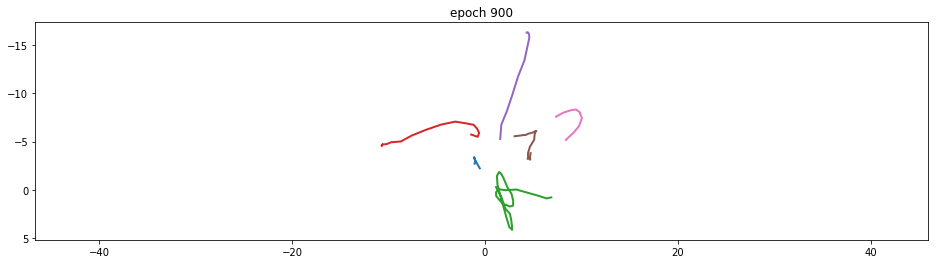

epoch 910, loss -6.077704906463623
epoch 920, loss -8.880718231201172
epoch 930, loss -15.354870796203613
epoch 940, loss 27.600061416625977
epoch 950, loss -46.963165283203125
epoch 960, loss -0.4205078184604645
epoch 970, loss -0.033203125
epoch 980, loss 46.2056999206543
epoch 990, loss 30.641845703125
epoch 1000, loss -39.917964935302734


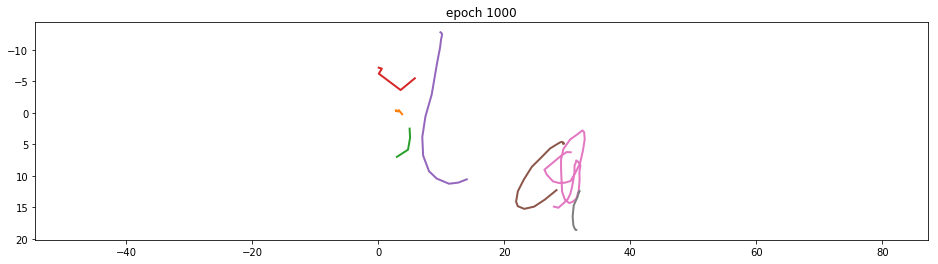

epoch 1010, loss 28.471214294433594
epoch 1020, loss -12.188410758972168
epoch 1030, loss -10.475299835205078
epoch 1040, loss -54.325096130371094
epoch 1050, loss -43.84966278076172
epoch 1060, loss 15.493730545043945
epoch 1070, loss -49.41575241088867
epoch 1080, loss 11.4888277053833
epoch 1090, loss 17.029748916625977
epoch 1100, loss 33.0034294128418


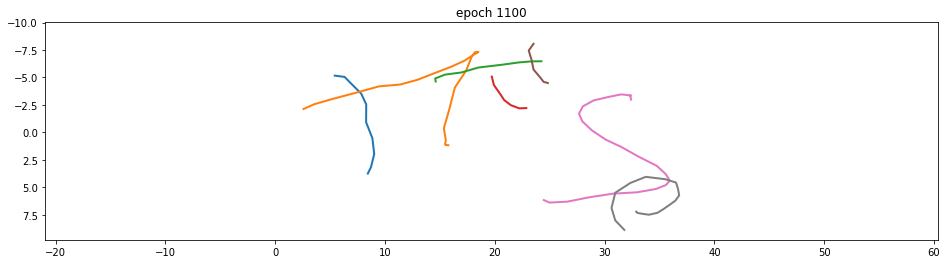

epoch 1110, loss -21.174909591674805
epoch 1120, loss -43.8532600402832
epoch 1130, loss 24.147441864013672
epoch 1140, loss 18.31338882446289
epoch 1150, loss -20.408214569091797
epoch 1160, loss 14.108240127563477
epoch 1170, loss 5.832258224487305
epoch 1180, loss 2.63232421875
epoch 1190, loss 17.239164352416992
epoch 1200, loss -15.963879585266113


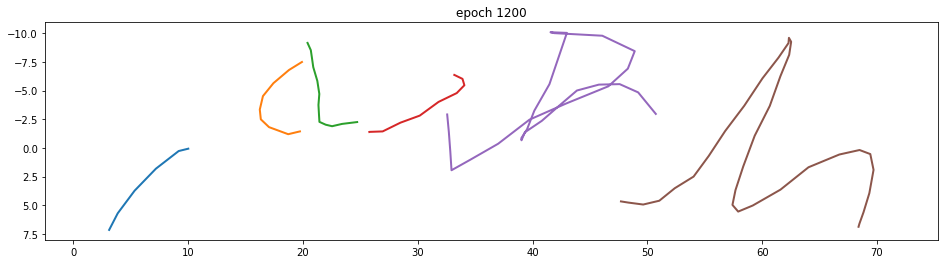

epoch 1210, loss 5.057543754577637
epoch 1220, loss -45.965576171875
epoch 1230, loss 38.580238342285156
epoch 1240, loss -9.004137992858887
epoch 1250, loss 7.846975326538086
epoch 1260, loss 27.1275691986084
epoch 1270, loss -12.459746360778809
epoch 1280, loss 9.994170188903809
epoch 1290, loss 60.549346923828125
epoch 1300, loss 12.531445503234863


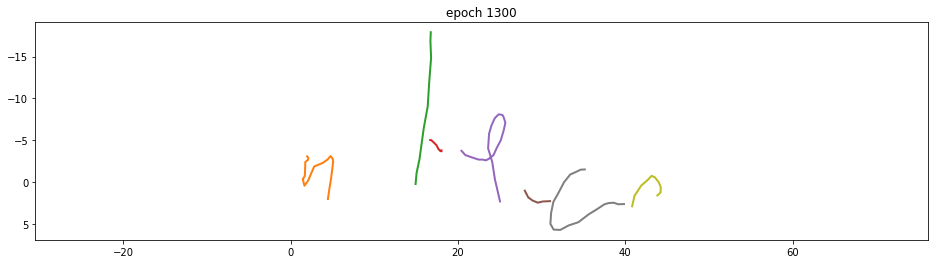

epoch 1310, loss 15.259377479553223
epoch 1320, loss -82.85916137695312
epoch 1330, loss 36.199798583984375
epoch 1340, loss 59.28404235839844
epoch 1350, loss 0.8053417801856995
epoch 1360, loss 11.641144752502441
epoch 1370, loss -23.248516082763672
epoch 1380, loss -63.078826904296875
epoch 1390, loss 31.523313522338867
epoch 1400, loss -24.447782516479492


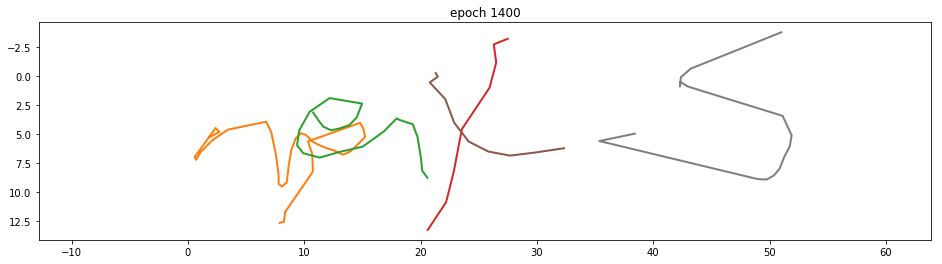

epoch 1410, loss -25.575571060180664
epoch 1420, loss -35.79767990112305
epoch 1430, loss -17.978504180908203
epoch 1440, loss -12.403229713439941
epoch 1450, loss 33.847232818603516
epoch 1460, loss -35.1059684753418
epoch 1470, loss 68.55838775634766
epoch 1480, loss -30.927474975585938
epoch 1490, loss 41.298423767089844
epoch 1500, loss 14.609016418457031


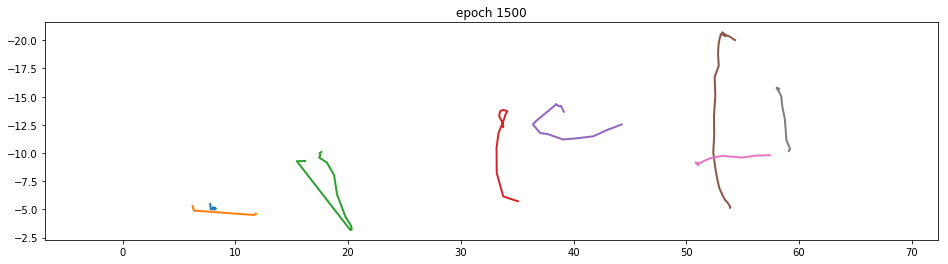

epoch 1510, loss -38.50157165527344
epoch 1520, loss 19.162742614746094
epoch 1530, loss -19.657323837280273
epoch 1540, loss -17.393653869628906
epoch 1550, loss -48.31954574584961
epoch 1560, loss -5.225107192993164
epoch 1570, loss -11.533738136291504
epoch 1580, loss 34.153175354003906
epoch 1590, loss -78.4946517944336
epoch 1600, loss -42.918338775634766


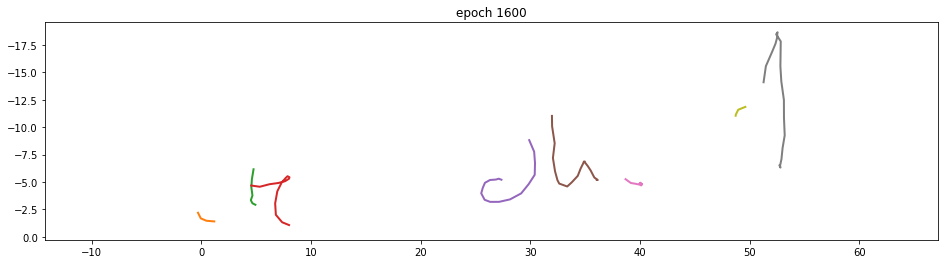

epoch 1610, loss -24.6572322845459
epoch 1620, loss 23.270532608032227
epoch 1630, loss 0.5204296708106995
epoch 1640, loss -69.6334457397461
epoch 1650, loss 22.252965927124023
epoch 1660, loss -6.726244926452637
epoch 1670, loss -10.145852088928223
epoch 1680, loss 21.76900863647461
epoch 1690, loss -35.749454498291016
epoch 1700, loss -53.18586730957031


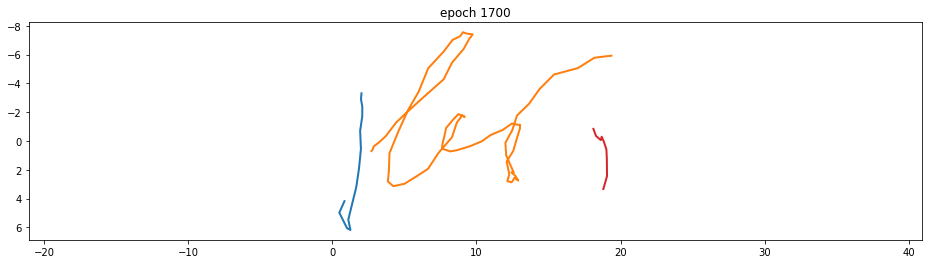

epoch 1710, loss 1.8196630477905273
epoch 1720, loss -9.545522689819336
epoch 1730, loss -19.975927352905273
epoch 1740, loss -55.423824310302734
epoch 1750, loss -26.180736541748047
epoch 1760, loss -27.9014835357666
epoch 1770, loss -4.602817535400391
epoch 1780, loss 16.799949645996094
epoch 1790, loss 59.613162994384766
epoch 1800, loss -15.319907188415527


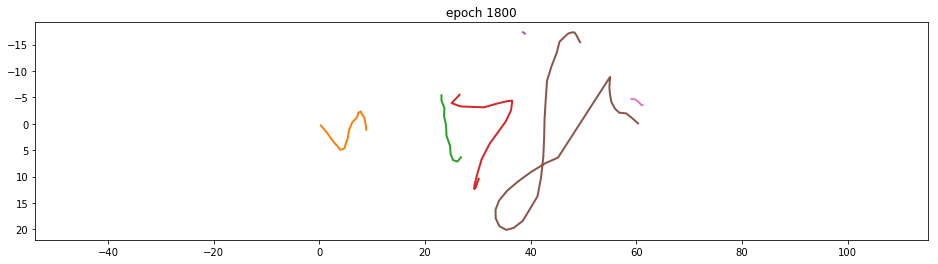

epoch 1810, loss 6.751349925994873
epoch 1820, loss -1.2747583389282227
epoch 1830, loss -47.929656982421875
epoch 1840, loss -18.68163299560547
epoch 1850, loss -26.596961975097656
epoch 1860, loss -4.664919376373291
epoch 1870, loss 21.00387954711914
epoch 1880, loss -32.00030517578125
epoch 1890, loss -5.804811954498291
epoch 1900, loss -47.35453796386719


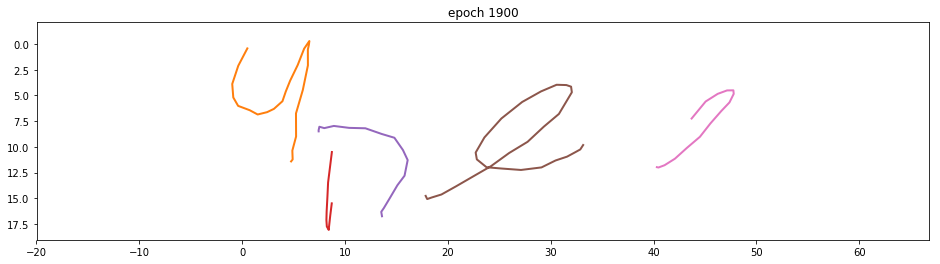

epoch 1910, loss -35.07452392578125
epoch 1920, loss -32.37730407714844
epoch 1930, loss -11.768806457519531
epoch 1940, loss 11.081140518188477
epoch 1950, loss 22.588315963745117
epoch 1960, loss -46.96044921875
epoch 1970, loss -11.381555557250977
epoch 1980, loss -57.81333923339844
epoch 1990, loss 15.627839088439941


In [19]:
net = GaussianHandWriting(dropout=0.2)
optimizer = optim.Adam(net.parameters(), lr=0.005)
max_epoch = 2000
info_freq = 10
save_freq = 100
max_norm = 10 # for gradient clipping

batch = batch_generator()
loss_log = []
hidden = None
for epoch in range(max_epoch):
    x = next(batch)
    optimizer.zero_grad()
    loss, hidden = net.calculate_loss(x[:-1], x[1:], hidden)
    loss.backward()
    torch.nn.utils.clip_grad_norm(net.parameters(), max_norm)
    optimizer.step()
    hidden.detach_()
    loss_log += loss.data.tolist()
    if epoch%info_freq == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data[0]))
    if epoch%save_freq ==0:
        # save model
        torch.save(net.state_dict(),'net_epoch_{:06d}.pt'.format(epoch))
        # check performance
        x0 = Variable(torch.Tensor([0,0,1]).view(1,1,3))
        data = net.generate(x0)
        plot_points(data)
        plt.title('epoch {}'.format(epoch))
        plt.show()

## Post evaluation code

In this stage, we can recreate the net without the dropout feature. The follwing code load saved parameters and generated a longer sequence. This way of saving and loading a model is recommended.

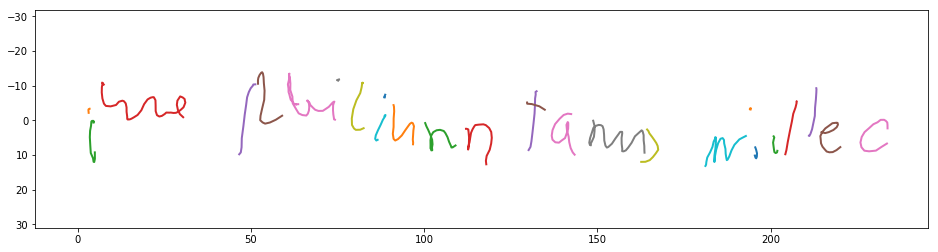

In [30]:
pt_file = 'net_epoch_001900.pt'

net = GaussianHandWriting()
net.load_state_dict(torch.load(pt_file))

x0 = Variable(torch.Tensor([0,0,1]).view(1,1,3))
data = net.generate(x0, n=500)
plot_points(data)

## Conclusion

At  epoch 0, the generated strokes are random segements. Strokes form recognizable shapes at 200 epoch. The genration quality keeps improving, even though the loss  does not decrease much. This will be used as a baseline model to compare with other models, such as GAN and VAE. Also I want to experiment with conditioned input as well.